# Fraud detection

## Load data

In [1]:
# import pandas as pd
# train_identity = pd.read_csv('../data/train_identity.csv')
# train_transaction = pd.read_csv('../data/train_transaction.csv')

# df_fraud = pd.merge(train_transaction, train_identity, on='TransactionID', how='left')
# df_fraud.to_csv('../data/data_fraud.csv', index=False)

In [2]:
import pandas as pd

df_fraud = pd.read_csv('../data/data_fraud.csv')

## EDA

In [3]:
df_fraud.head(10)

,TransactionID,isFraud,TransactionDT,TransactionAmt,ProductCD,card1,card2,card3,card4,card5,...,id_31,id_32,id_33,id_34,id_35,id_36,id_37,id_38,DeviceType,DeviceInfo
0,2987000,0,86400,68.5,W,13926,NaN,150.0,discover,142.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2987001,0,86401,29.0,W,2755,404.0,150.0,mastercard,102.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,2987002,0,86469,59.0,W,4663,490.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,2987003,0,86499,50.0,W,18132,567.0,150.0,mastercard,117.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
4,2987004,0,86506,50.0,H,4497,514.0,150.0,mastercard,102.0,...,samsung browser 6.2,32.0,2220x1080,match_status:2,T,F,T,T,mobile,SAMSUNG SM-G892A Build/NRD90M
5,2987005,0,86510,49.0,W,5937,555.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,2987006,0,86522,159.0,W,12308,360.0,150.0,visa,166.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
7,2987007,0,86529,422.5,W,12695,490.0,150.0,visa,226.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
8,2987008,0,86535,15.0,H,2803,100.0,150.0,visa,226.0,...,mobile safari 11.0,32.0,1334x750,match_status:1,T,F,F,T,mobile,iOS Device
9,2987009,0,86536,117.0,W,17399,111.0,150.0,mastercard,224.0,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


Visually, we can see a lot of missing values.

In [4]:
df_fraud.shape

(590540, 434)

We have o lot of columns so we have to reduce the dimension

In [5]:
df_fraud.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 590540 entries, 0 to 590539
Columns: 434 entries, TransactionID to DeviceInfo
dtypes: float64(399), int64(4), object(31)
memory usage: 1.9+ GB


We have a lot of object columns, which we will need to convert to numerical columns.

In [6]:
nb_missing_values = df_fraud.isnull().sum().sum()
percentage_missing_values = round(100*nb_missing_values / (df_fraud.shape[0] * df_fraud.shape[1]), 1)
print(f'Missing values: {nb_missing_values} ({percentage_missing_values}%)')

Missing values: 115523073 (45.1%)


We have a lot of missing values: more than 45%

In [7]:
missing_data_count = df_fraud.isnull().sum()
missing_data_percentage = round((missing_data_count / len(df_fraud)) * 100, 1)

missing_data_stats = pd.DataFrame({
    'Missing data (count)': missing_data_count,
    'Missing data (%)': missing_data_percentage
})

missing_data_stats.sort_values(by='Missing data (%)', ascending=False).head(10)

,Missing data (count),Missing data (%)
id_24,585793,99.2
id_25,585408,99.1
id_26,585377,99.1
id_21,585381,99.1
id_22,585371,99.1
id_23,585371,99.1
id_08,585385,99.1
id_07,585385,99.1
id_27,585371,99.1
dist2,552913,93.6


In [8]:
# drop columns with more than 60% missing values

columns_to_drop = missing_data_stats[missing_data_stats['Missing data (%)'] > 60].index
df_fraud.drop(columns=columns_to_drop, inplace=True)


In [9]:
df_fraud.shape

(590540, 226)

For some columns, the missing data percentage is very high. We will have to see if we delete them or if the missing values give information.

## Encoding

To encode object data, we use a OneHotEncoder

In [10]:
from sklearn.preprocessing import OneHotEncoder

object_df = df_fraud.select_dtypes(include=['object'])

encoder = OneHotEncoder(drop='first')
encoded_data = encoder.fit_transform(object_df)

categories = encoder.categories_

encoded_columns = []
for i, col in enumerate(object_df.columns):
    encoded_columns.extend([f"{col}_{category}" for category in categories[i][1:]])

encoded_df = pd.DataFrame(encoded_data.toarray(), columns=encoded_columns)

df_fraud = df_fraud.drop(columns=object_df.columns)
df_fraud = pd.concat([df_fraud, encoded_df], axis=1)

In [11]:
df_fraud.shape

(590540, 303)

Now we have an even higher number of columns.

Let's see the linear correlation between the columns and the output.

In [12]:
correlation = df_fraud.drop('isFraud', axis=1).corrwith(df_fraud['isFraud']).apply(abs).sort_values(ascending=False)
correlation.head()

V45    0.281832
V44    0.260376
V86    0.251828
V87    0.251737
V52    0.239469
dtype: float64

Some columns have a quite high correlation with the output. We can try to eliminate the variables with the lowest correlation.

In [13]:
import numpy as np
import plotly.graph_objects as go

fig = go.Figure()
thresholds = np.arange(0, correlation[0], 0.005)
nb_col2drop = []

for threshold in thresholds:
    columns_to_drop = correlation[correlation < threshold].index
    nb_col2drop.append(len(columns_to_drop))

fig.add_trace(go.Scatter(x=thresholds, y=nb_col2drop, mode='lines+markers'))
fig.update_layout(title='Number of columns to drop depending on the correlation threshold',
                  xaxis_title='Threshold',
                  yaxis_title='Number of columns to drop')


If we eliminate all the columns which have a correlation lower than 0.05, we still keep a lot of columns. But we eliminate more than 2000 variable, most of them are from the encoder which mean some values of the encoder don't have correlation with the output.

In [14]:
threshold = 0.05
columns_to_drop = correlation[correlation < threshold].index

In [15]:
df_fraud_filtered = df_fraud.drop(columns=columns_to_drop)

print(f'Columns dropped: {columns_to_drop}\n')
print(f'Elimated columns: {len(columns_to_drop)}')
print(f'Missing values eliminated: {df_fraud.isnull().sum().sum() - df_fraud_filtered.isnull().sum().sum()}')

Columns dropped: Index(['V117', 'V61', 'V3', 'V315', 'V119', 'V53', 'V76', 'D3', 'V13', 'D11',
       ...
       'V88', 'V305', 'P_emaildomain_mac.com', 'V299', 'V135', 'V137', 'V319',
       'P_emaildomain_embarqmail.com', 'V136', 'P_emaildomain_yahoo.fr'],
      dtype='object', length=193)

Elimated columns: 193
Missing values eliminated: 5080478


By eliminating these 2618 columns, we also have eliminated almost half of the missing values.

In [16]:
df_fraud_filtered.head()

,isFraud,card3,D1,D2,D4,D5,D10,D15,V10,V11,...,M3_T,M3_nan,M4_M2,M4_nan,M6_T,M6_nan,M7_nan,M8_nan,M9_T,M9_nan
0,0,150.0,14.0,NaN,NaN,NaN,13.0,0.0,0.0,0.0,...,1.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
1,0,150.0,0.0,NaN,0.0,NaN,0.0,0.0,NaN,NaN,...,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0
2,0,150.0,0.0,NaN,0.0,NaN,0.0,315.0,0.0,0.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0,150.0,112.0,112.0,94.0,0.0,84.0,111.0,NaN,NaN,...,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0
4,0,150.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.0,1.0,0.0,1.0,0.0,1.0,1.0,1.0,0.0,1.0


In [17]:
df_fraud_filtered.to_csv('../data/data_fraud_filtered.csv', index=False)

In [18]:
df_fraud_filtered.shape

(590540, 110)

## Preprocessing

### Load encoded data

In [36]:
import pandas as pd

df_fraud_filtered = pd.read_csv('../data/data_fraud_filtered.csv')

Now, we are going to impute values to train models on it.

### Imputation of data

In [20]:
from sklearn.experimental import enable_iterative_imputer
from sklearn.impute import IterativeImputer

import warnings
warnings.filterwarnings('ignore')

imputer = IterativeImputer(n_nearest_features=10, random_state=42)
imputer.fit(df_fraud_filtered)
df_fraud_imputed = imputer.transform(df_fraud_filtered)
df_fraud_imputed = pd.DataFrame(df_fraud_imputed, columns=df_fraud_filtered.columns)

In [21]:
df_fraud_imputed.to_csv('../data/data_fraud_imputed.csv', index=False)

Now we can reduce again the dimension eliminating multicolinearity. To do this, we are going to use the Variance Inflation Factor (VIF). A VIF higher than 10 reveals a high multicolinearity so we can delete these variables.

Calculating the VIF require a lot of time so we are going to use a random sample to eliminate the multicolinearity.

### Delete multicolinearity with VIF on a sample

In [37]:
import pandas as pd

df_fraud_imputed = pd.read_csv('../data/data_fraud_imputed.csv')

In [23]:
size_sample = 5000
df_sampled = df_fraud_imputed.sample(n=size_sample, random_state=42)

In [24]:
from utils import delete_multicollinearity

df_fraud_preprocessed = delete_multicollinearity(df_sampled, 'isFraud', 10)

Dropped column M9_nan with VIF: inf (5s)
Dropped column M8_nan with VIF: inf (5s)
Dropped column M3_nan with VIF: inf (5s)
Dropped column M2_nan with VIF: inf (5s)
Dropped column V111 with VIF: 1945.1 (4s)
Dropped column V108 with VIF: 1340.7 (4s)
Dropped column M1_T with VIF: 752.6 (4s)
Dropped column V113 with VIF: 708.9 (4s)
Dropped column V116 with VIF: 459.1 (4s)
Dropped column card6_debit with VIF: 332.3 (4s)
Dropped column V110 with VIF: 327.3 (4s)
Dropped column V17 with VIF: 280.4 (4s)
Dropped column V58 with VIF: 267.7 (4s)
Dropped column V46 with VIF: 229.8 (3s)
Dropped column V112 with VIF: 219.9 (3s)
Dropped column card3 with VIF: 194.1 (3s)
Dropped column V114 with VIF: 182.7 (3s)
Dropped column V93 with VIF: 149.3 (3s)
Dropped column V23 with VIF: 136.5 (3s)
Dropped column V31 with VIF: 126.1 (3s)
Dropped column V109 with VIF: 110.3 (3s)
Dropped column V123 with VIF: 95.4 (3s)
Dropped column V42 with VIF: 93.5 (3s)
Dropped column V16 with VIF: 88.3 (3s)
Dropped column V1

In [38]:
columns_to_keep = list(df_fraud_preprocessed.columns) + ['isFraud']
df_fraud_final = df_fraud_imputed[columns_to_keep]

In [39]:
df_fraud_final.shape

(590540, 34)

Now we have 59 columns to train our models.

In [27]:
correlation = df_fraud_final.drop('isFraud', axis=1).corrwith(df_fraud_final['isFraud']).apply(abs).sort_values(ascending=False)
correlation.head()

V45    0.241439
V74    0.180333
V79    0.176234
V40    0.174961
V63    0.154407
dtype: float64

Some of these columns have a good correlation with the output.

In [28]:
df_fraud_final.to_csv('../data/data_fraud_final.csv', index=False)

In [40]:
import pandas as pd

df_fraud_preprocessed = pd.read_csv('../data/data_fraud_final.csv')

In [41]:
df_fraud_preprocessed.columns

Index(['D2', 'D4', 'D5', 'D10', 'D15', 'V12', 'V22', 'V30', 'V36', 'V40',
       'V45', 'V56', 'V60', 'V62', 'V63', 'V70', 'V74', 'V75', 'V78', 'V79',
       'V82', 'V281', 'V282', 'V283', 'V303', 'card6_credit', 'M1_nan', 'M3_T',
       'M4_M2', 'M6_T', 'M6_nan', 'M9_T', 'isFraud'],
      dtype='object')

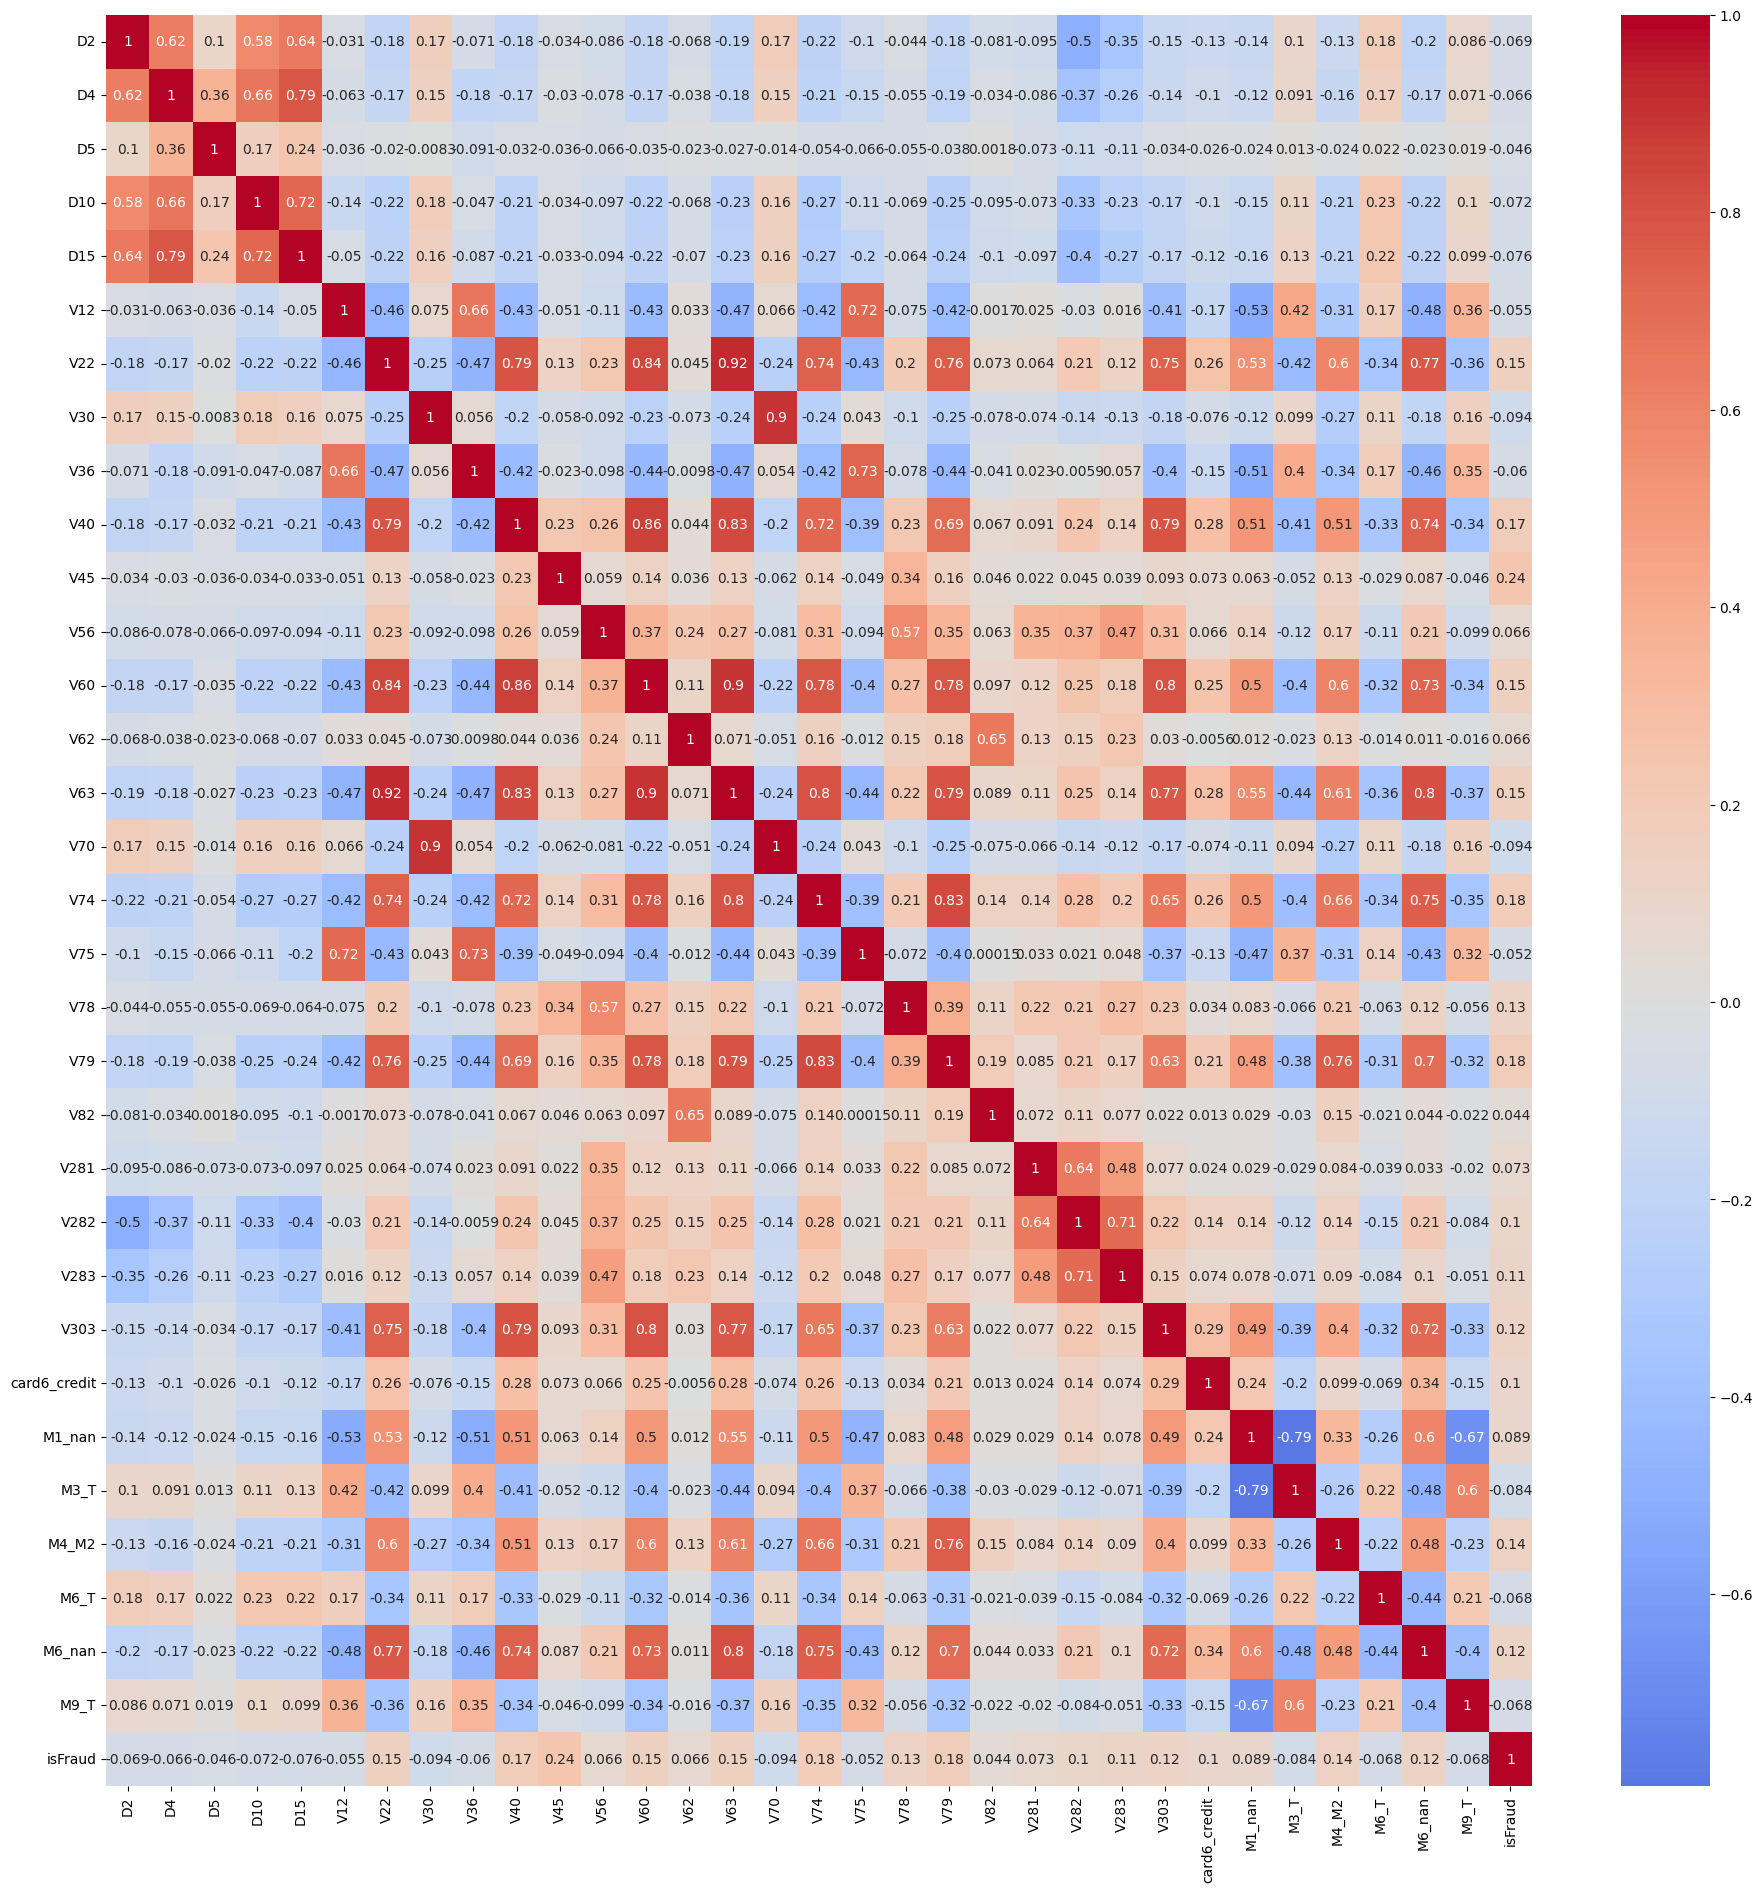

In [44]:
# heatmap of the correlation matrix showing the value of the correlation coefficient
import seaborn as sns
import matplotlib.pyplot as plt


plt.figure(figsize=(23, 23))

sns.heatmap(df_fraud_preprocessed.corr(), annot=True, cmap='coolwarm', center=0)
plt.show()


In [32]:
col_eda = ['D2', 'D4', 'D5', 'D10', 'D15', 'V12', 'V22', 'V30', 'V36', 'V40']
data_eda = df_fraud_preprocessed[col_eda]

In [33]:
data_eda.describe()

,D2,D4,D5,D10,D15,V12,V22,V30,V36,V40
count,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000,590540.000000
mean,91.273735,138.788598,33.968343,116.021565,154.327641,0.505598,0.175581,0.413451,0.550874,0.232755
std,154.674688,174.496901,62.737528,172.740423,190.323319,0.497391,0.357500,0.520480,0.482501,0.491472
min,-57.101829,-419.230992,-141.067547,-136.326287,-741.872495,-0.489545,-0.246607,-0.243705,-0.657509,-0.265429
25%,0.000000,0.000000,9.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,4.935475,71.128466,22.000000,41.000000,83.000000,0.152209,0.000000,0.000000,0.438496,0.000000
75%,115.000000,222.858328,29.357035,157.000000,263.475069,1.000000,0.000000,1.000000,1.000000,0.050732
max,640.000000,869.000000,819.000000,876.000000,879.000000,3.000000,8.000000,9.000000,5.000000,24.000000


The repartition of the values is very umbalanced. For exemple, for 'V34', we have the same 1st and 3rd quartile (0), which means that more than 75% of the values are equal to 0. The same goes for 'V56' and 'V70'.

### Histplot

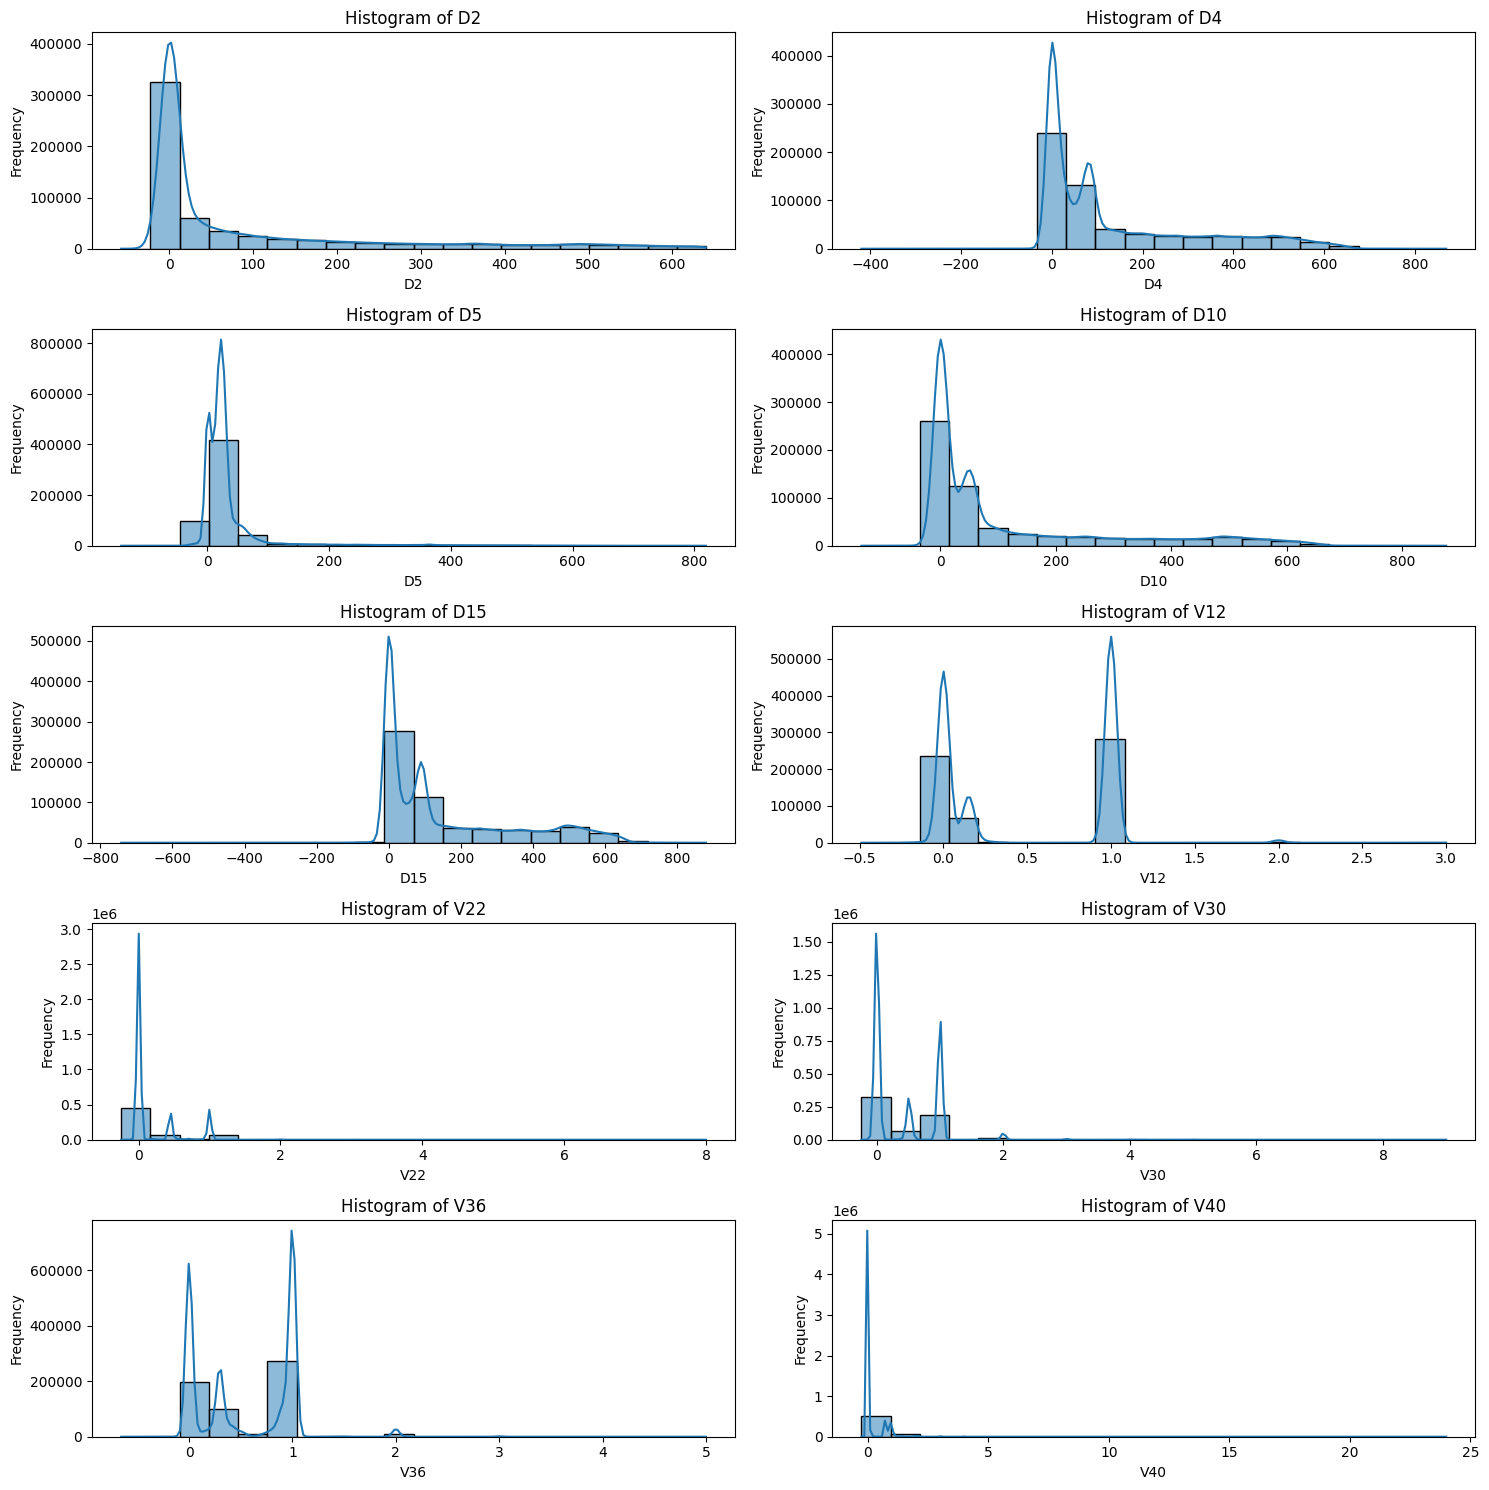

In [34]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.histplot(data=data_eda, x=var, bins=20, kde=True, ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_ylabel('Frequency')
    axes[i].set_title(f'Histogram of {var}')

plt.tight_layout()
plt.show()


With these histoplot, we can validate that the data is very unbalanced. We can see that the data is very skewed and that the distribution is not normal. This can be because of the presence of outliers in the data. We can also see that the data is very sparse, with a lot of zeros in the data. This can be because of the presence of missing values in the data.

Let's see if we have outliers with plot

### Boxplot

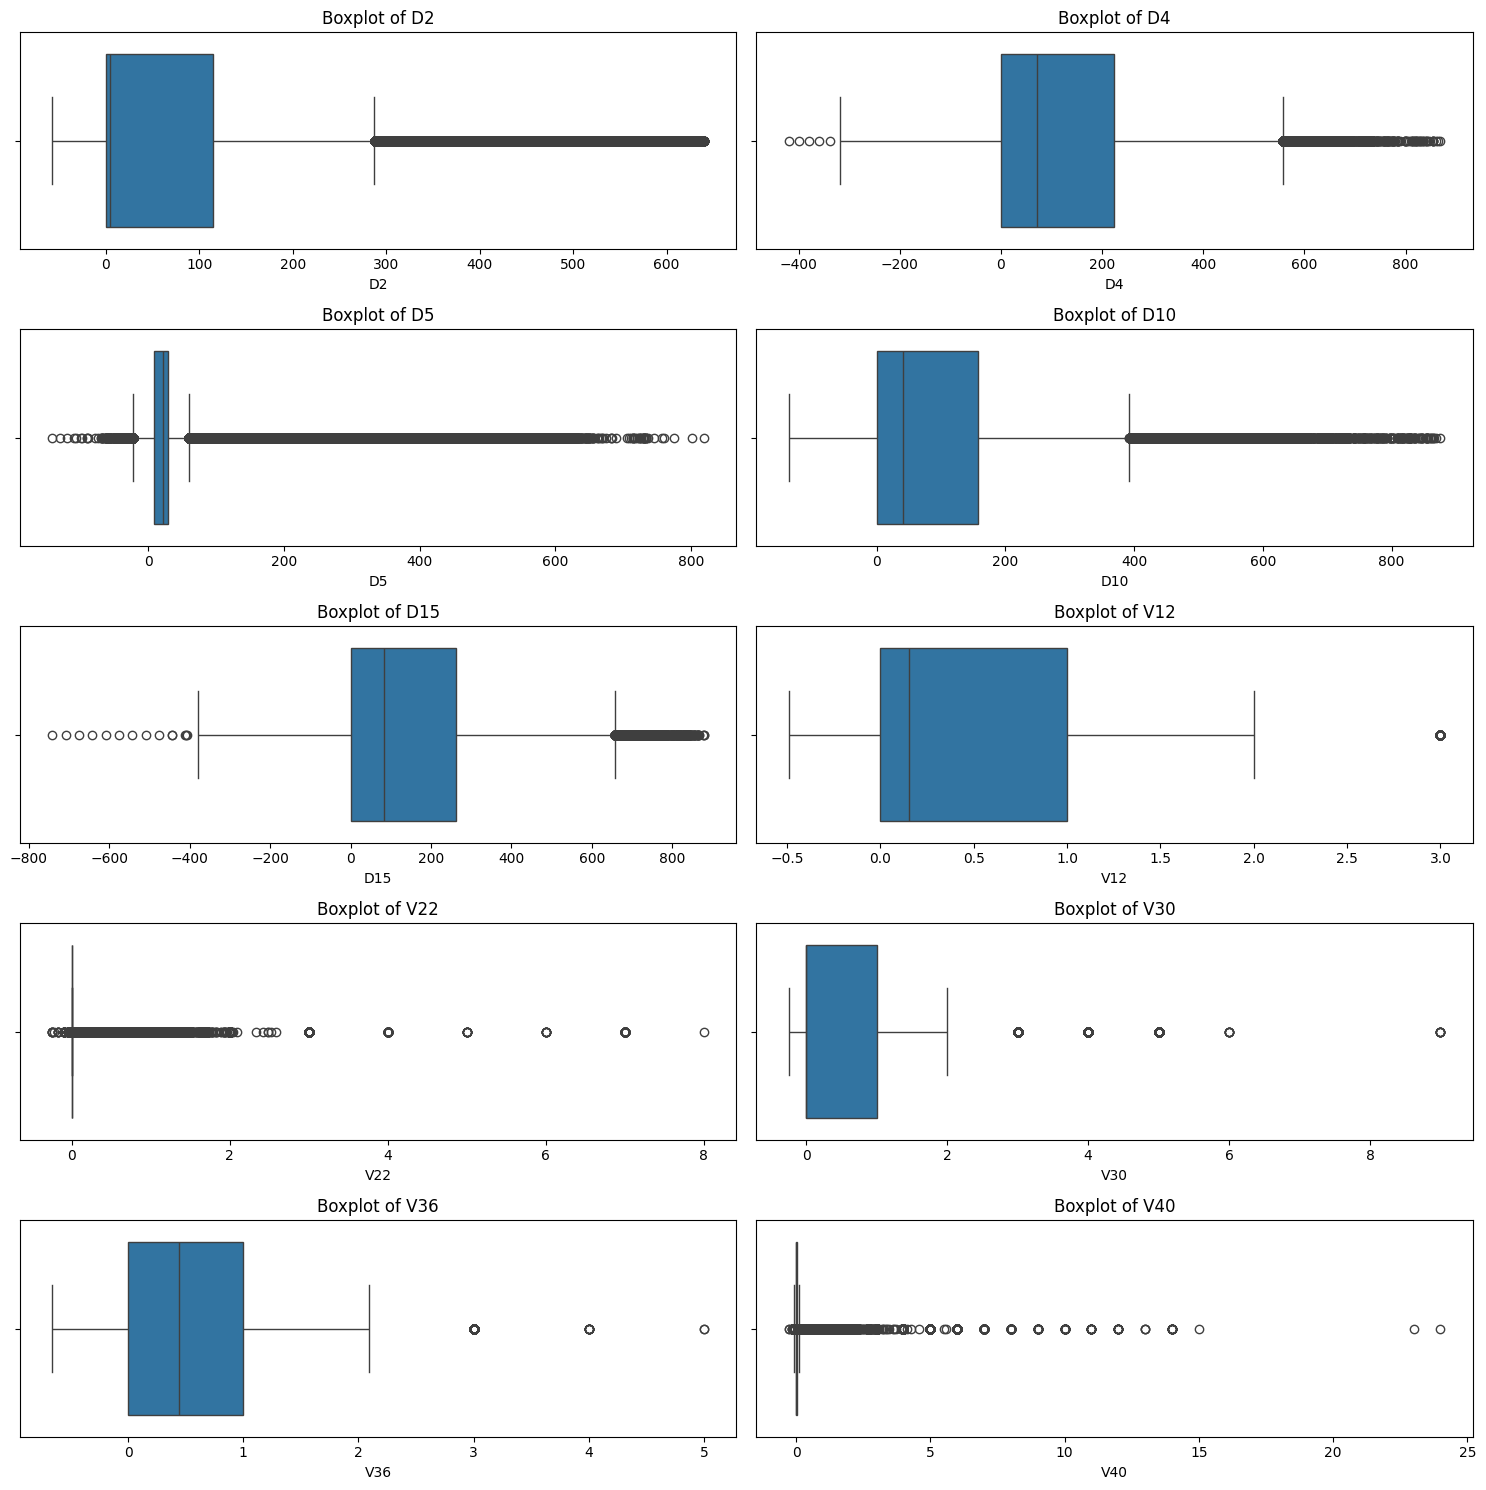

In [35]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, axes = plt.subplots(5, 2, figsize=(15, 15))
axes = axes.flatten()

for i, var in enumerate(data_eda.columns):
    sns.boxplot(x=data_eda[var], ax=axes[i])
    axes[i].set_xlabel(var)
    axes[i].set_title(f'Boxplot of {var}')

plt.tight_layout()
plt.show()

We these plots, we can see that the variables have a lot of outliers. This can be beacause of the missing values and the imputation with the IterativeImputer.
We will keep these outliers for now.